In [ ]:
# I thoroughly recorded my daily activities for almost a year.
# In this notebook, I tried to classify them and make some visualizations.
import io
import re
import datetime
import collections
import os.path
from matplotlib import pyplot as plt

%matplotlib inline

In [5]:
def parse_life(stream, start_year):
    current_year = start_year
    current_date = None
    parsed_current_date = None
    for line in stream:
        line = line.rstrip()
        if re.match('^\\s*$', line):
            continue
        if re.match('^[0-9]{1,2} \w{3}$', line):
            current_date = line
            next_line = next(stream).rstrip()
            assert re.match('^-+$', next_line), "Expected dashes, got {}".format(next_line)
            parsed_time = datetime.datetime.strptime(current_date, "%d %b")
            if parsed_time.month == 1 and parsed_current_date.month != parsed_time.month:
                current_year += 1
            parsed_current_date = parsed_time.replace(year=current_year)
            continue
        try:
            interval, description = line.split(' ', 1)
            from_, to = interval.split('-')
            from_time = datetime.datetime.strptime(from_, "%H:%M").time()
            to_time = datetime.datetime.strptime(to, "%H:%M").time()
        except ValueError:
            raise ValueError('Parse failure: "{}"'.format(line))

        from_datetime = datetime.datetime.combine(parsed_current_date, from_time)
        to_datetime = datetime.datetime.combine(parsed_current_date, to_time)
        assert current_date is not None
        assert from_datetime <= to_datetime, "from > to: {}".format(line)
        yield from_datetime, to_datetime, description


def words(description):
    return [word.lower() for word in re.split('\W+', description)]


def classify(description):
    wds = words(description)
    return [CLASSES[wd] for wd in wds if wd in CLASSES]


def main():
    with io.open(os.path.expanduser('data/life.txt'), encoding='utf-8') as stream:
        entries = list(parse_life(stream, 2018))

    unclassified = collections.defaultdict(datetime.timedelta)
    classified = collections.defaultdict(datetime.timedelta)

    unclassified_total = datetime.timedelta()
    classified_total = datetime.timedelta()

    for start, end, description in entries:
        tags = classify(description)
        for tag in tags:
            classified[tag] += end - start
        if not tags:
            for word in words(description):
                unclassified[word] += end - start
            unclassified_total += end - start
        else:
            classified_total += end - start
        yield start, end, description, tags

    print(unclassified_total, classified_total)
    print("---")
    for tag, dur in classified.items():
        print(tag, dur)
    print("---")
    for value, word in reversed(sorted([(value, word) for word, value in unclassified.items()])):
        print('{:20} {}'.format(word, value))

In [ ]:
CLASSES = collections.OrderedDict([
    ["говорили", "communication"],
    ["поговорили", "communication"],
    ["поговорил", "communication"],
    ["общался", "communication"],
    ["общались", "communication"],
    ["обсуждали", "communication"],
    ["обсудили", "communication"],
    ["ответил", "communication"],
    ["мишей", "communication"],
    ["кириллом", "communication"],
    ["чаты", "communication"],
    ["ревью", "code_review"],
    ["поревьювил", "code_review"],
    ["ревьювил", "code_review"],
    ["встреча", "meeting"],
    ["стендап", "meeting"],
    ["планирование", "meeting"],
    ["тесты", "writing_code"],
    ["тестировал", "writing_code"],
    ["тестил", "writing_code"],
    ["переписал", "writing_code"],
    ["переписыванием", "writing_code"],
    ["переделал", "writing_code"],
    ["дописал", "writing_code"],
    ["писал", "writing_code"],
    ["писать", "writing_code"],
    ["фикс", "writing_code"],
    ["фиксы", "writing_code"],
    ["пофиксил", "writing_code"],
    ["правил", "writing_code"],
    ["поправил", "writing_code"],
    ["подправил", "writing_code"],
    ["допилил", "writing_code"],
    ["допиливал", "writing_code"],
    ["накидал", "writing_code"],
    ["прототип", "writing_code"],
    ["черновик", "writing_code"],
    ["рефакторил", "writing_code"],
    ["отрефакторил", "writing_code"],
    ["дорефакторил", "writing_code"],
    ["шлифовал", "writing_code"],
    ["подрихтовал", "writing_code"],
    ["подчистил", "writing_code"],
    ["почистил", "writing_code"],
    ["довел", "writing_code"],
    ["выпилил", "writing_code"],
    ["упрощаю", "writing_code"],
    ["причесывал", "writing_code"],
    ["причесал", "writing_code"],
    ["думал", "investigating"],
    ["подумал", "investigating"],
    ["разбирался", "investigating"],
    ["разобрался", "investigating"],
    ["посмотрел", "investigating"],
    ["разбирались", "investigating"],
    ["разобрались", "investigating"],
    ["исследовал", "investigating"],
    ["изучал", "investigating"],
    ["читал", "investigating"],
    ["расследовал", "investigating"],
    ["поисследовал", "investigating"],
    ["сравнивал", "investigating"],
    ["смотрел", "investigating"],
    ["смотреть", "investigating"],
    ["проверил", "investigating"],
    ["проверяю", "investigating"],
    ["сформулировал", "investigating"],
    ["запустил", "maintenance"],
    ["ждал", "maintenance"],
    ["посчитал", "maintenance"],
    ["поставил", "maintenance"],
    ["обновил", "maintenance"],
    ["считаться", "maintenance"],
    ["пересчитал", "maintenance"],
    ["пересчет", "maintenance"],
    ["настроил", "maintenance"],
    ["настраивал", "maintenance"],
])

items = list(main())

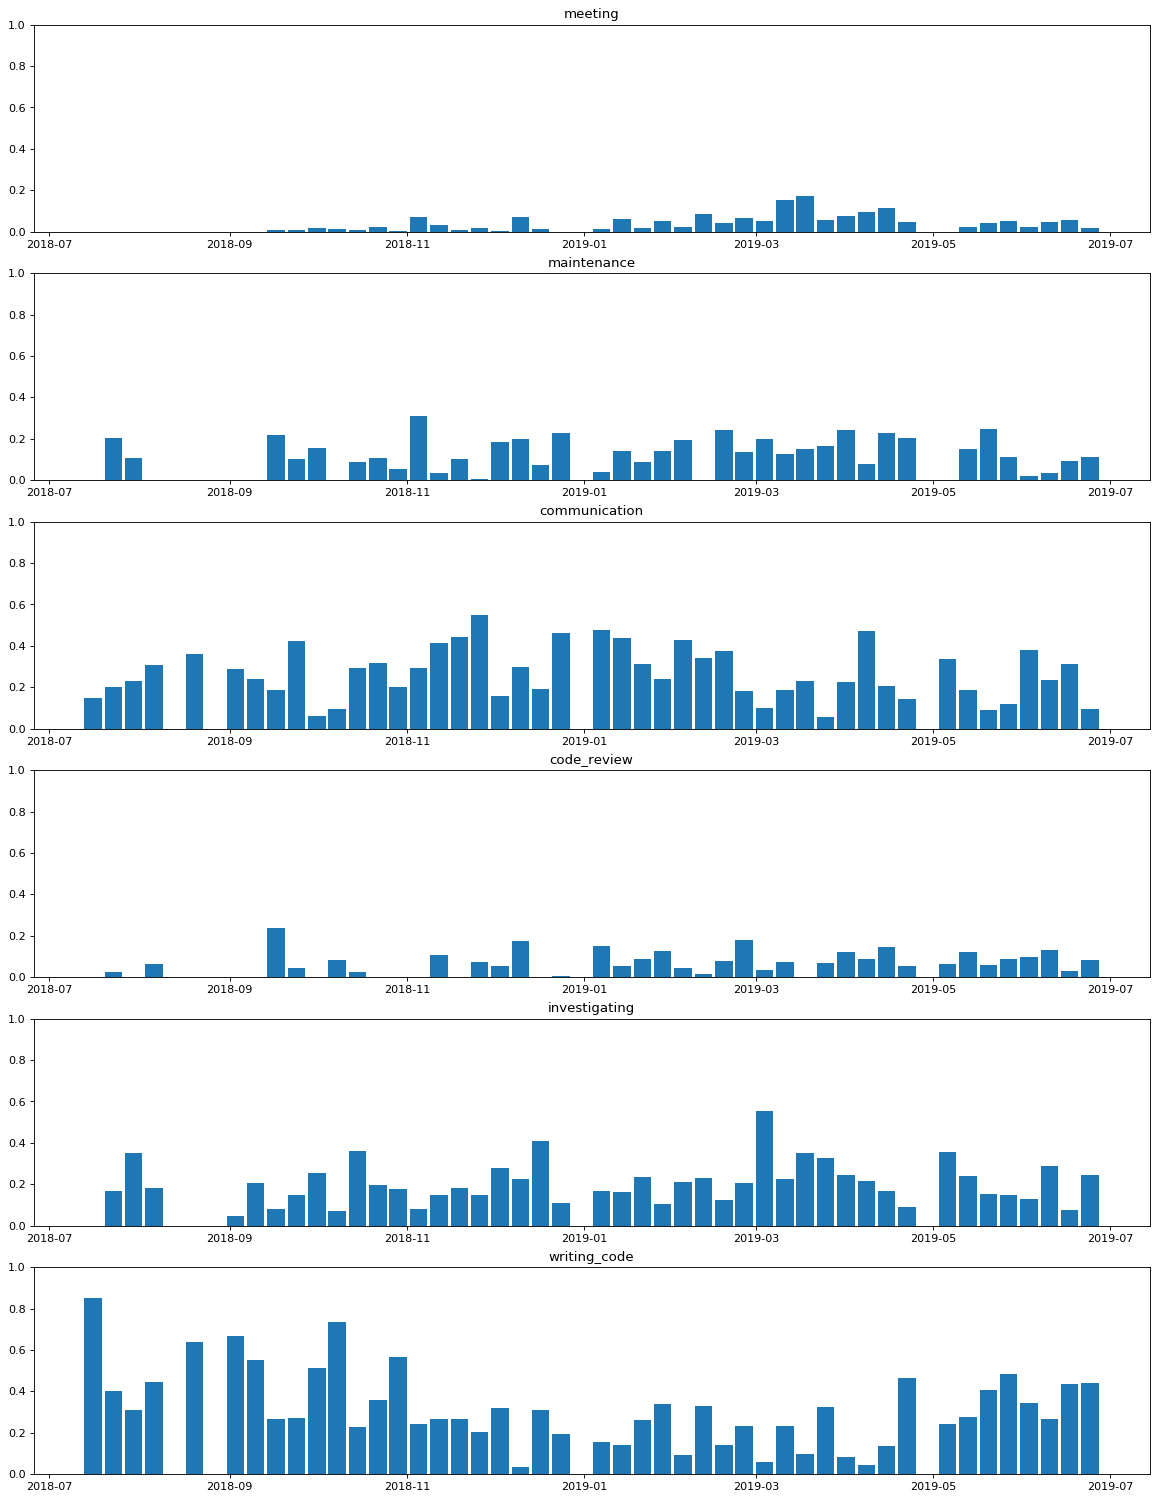

In [62]:
plt.figure(figsize=(18, 24), dpi=80)
tags_by_week = collections.defaultdict(datetime.timedelta)
for start, end, description, tags in items:
    week = (start - datetime.timedelta(start.weekday())).date()
    for tag in tags:
        tags_by_week[week, tag] += end - start

all_tags = {tag for _, tag in tags_by_week}
weeks = [week for week, _ in tags_by_week]

shares_by_week = {(week, tag): tags_by_week[week, tag] / sum([tags_by_week.get((week, t), datetime.timedelta()) for t in all_tags], datetime.timedelta()) for week, tag in tags_by_week}


for idx, tag in enumerate(all_tags, start=1):
    plt.subplot(len(all_tags), 1, idx)
    plt.title(tag)
    plt.ylim([0, 1])
    plt.bar(weeks, [shares_by_week.get((w, tag), 0) for w in weeks], width=datetime.timedelta(days=6))

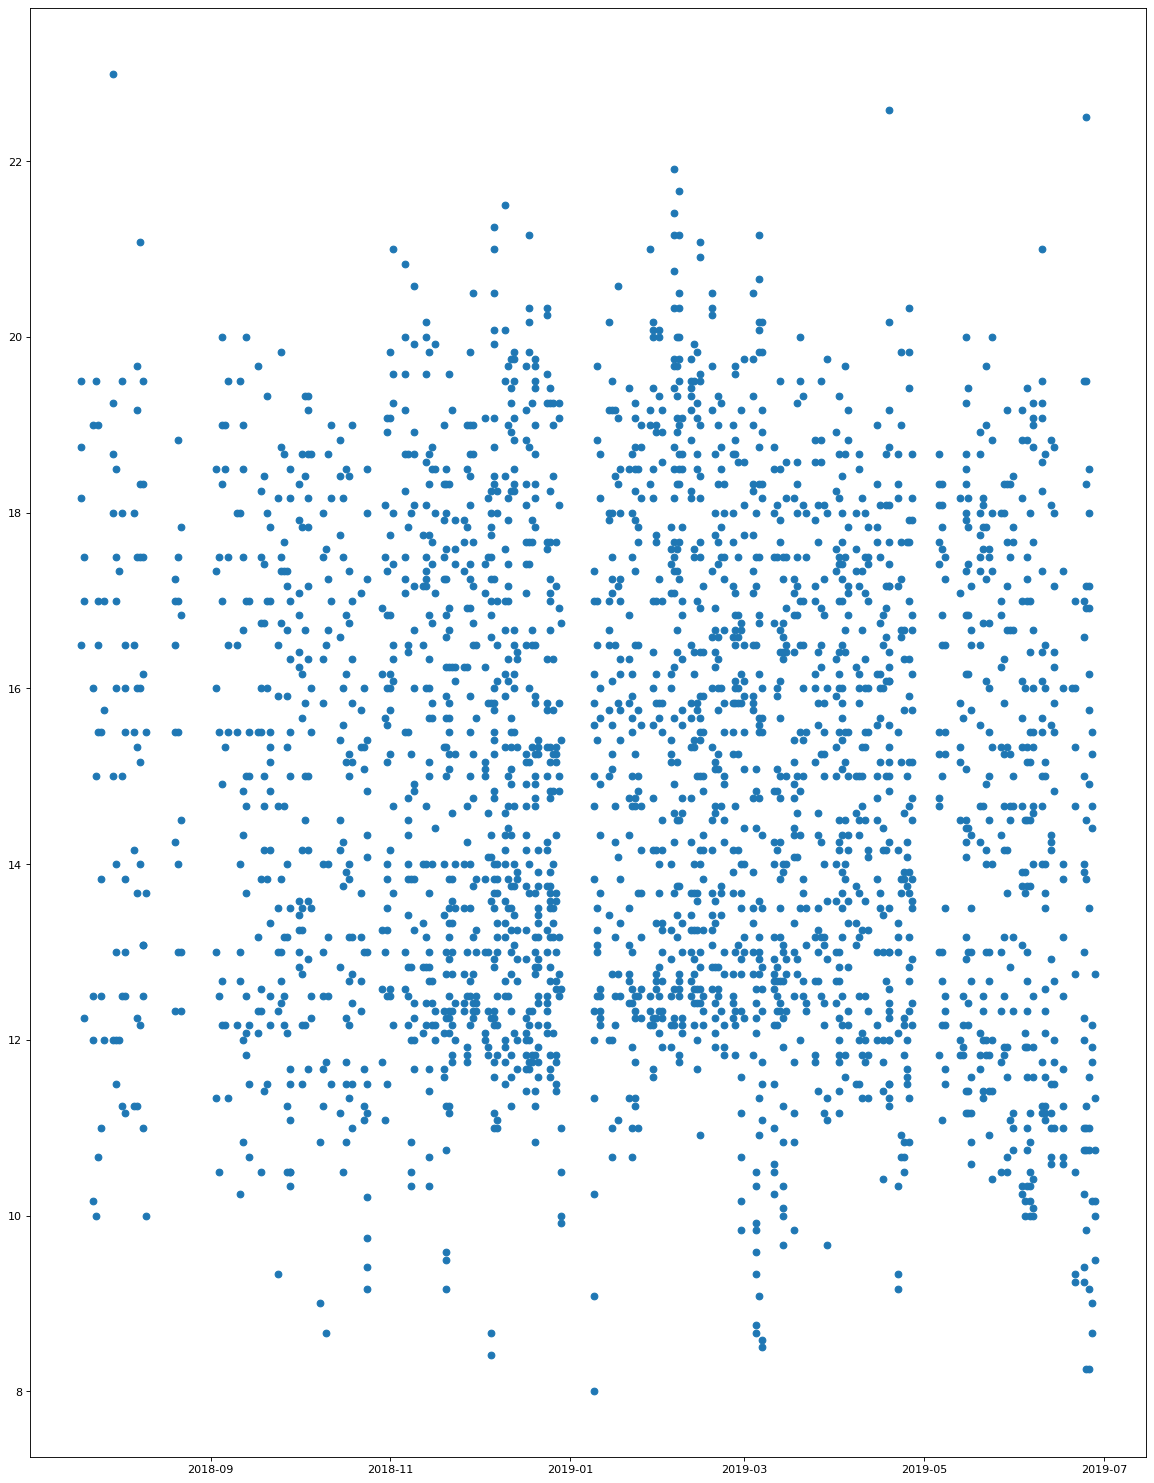

In [75]:
plt.figure(figsize=(18, 24), dpi=80)
xys = [(start.date(), start.time()) for start, _, _, _ in items]
plt.plot_date([p[0] for p in xys], [p[1].hour + p[1].minute / 60.0 for p in xys])